<div style="display:block">
    <div style="width: 20%; display: inline-block; text-align: left;">
        <img src="https://styleguide.ischool.syr.edu/assets/logos/block/iSchoolBlock-OutlineswithSyracuseUniversity_Orange.png" style="height:75px; margin-left:0px" />
    </div>
    <div style="width: 59%; display: inline-block">
        <h1  style="text-align: center">COVID-19 Literature Clustering</h1>
        <div style="width: 100%; text-align: center; display: inline-block;"><i>Group-2:</i> <strong>Litin, Nikita, Hua, Meena</strong> </div>
    </div>
    <div style="width: 20%; text-align: right; display: inline-block;">
        <div style="width: 100%; text-align: left; display: inline-block;">
            <i>Created: </i>
            <time datetime="2016-08-19" pubdate>April 18th, 2020</time>
        </div>
        <div style="width: 100%; text-align: left; display: inline-block;">
            <i>Modified: </i>
            <time datetime="2016-08-19" pubdate>May 05th, 2020</time>
        </div>
    </div>
</div>

## Introduction

Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. We believe clustering similar research articles together simplify the search for related publications.

This is a difficult time in which health care workers, sanitation staff, and many other essential personnel are out there keeping the world afloat. While adhering to quarantine protocol, the Kaggle CORD-19 dataset has given us an opportunity to help in the best way we can as computer science students. 

It should be noted, however, that we are not epidemiologists, and it is not our place to gauge the importance of these papers. This tool was created to help make it easier for trained professionals to sift through many, many publications related to the virus, and find their own determinations.

## Problem Statement

The main objective of this notebook is to cluster similar research articles together simplofy the search for related publiations. By using clustering for labelling in combination with dimensionality reduction for visualization, the collection of literature can be represented by a scatter plot. On this plot, publications of highly similar topic will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modelling will be performed to find the keywords of each cluster.

## Solution Approach

1.	Data pre-processing: to get a clean dataset by treating NAs, duplicates etc.
2.	Text Preprocessing: the preprocessing step usually consists of the tasks such as tokenization and filtering out stop words and vectorization
3.	TF-IDF: by using the TF-IDF weight, the document search can deliver results that are most relevant to what is searched for
4.	Clustering: we use k-means clustering to partition n documents in the context of text data into k clusters. representative around which the clusters are built
5.	Dimensionality reduction: this is done using PCA to obtain optimal number of components that capture the greatest amount of variance
6.	Topic Modeling: using LDA (Latent Dirichlet Allocation) for mapping a specific article into the topic space, we can then find related articles
7.	Classification: build three classification models that can be used for recommending similar literatures


## Table of contents

1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Topic Modeling usin LDA
6. Supervised Learning-Classification
7. Conclusion
8. Appendix

## Loading the data

In [52]:
#Loading the necessary libraries
import os
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import count,when,isnan,col,sum,isnull,corr,log,mean,exp
from pyspark.ml import feature
from pyspark.ml import classification,regression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import Row
from pyspark.sql.functions import lit
from pyspark.sql import functions as F
from pyspark.sql.types import (
    ArrayType,
    IntegerType,
    MapType,
    StringType,
    StructField,
    StructType,
    FloatType,
    DoubleType
)
import glob
import json
from pathlib import Path
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer,OneHotEncoder, StringIndexer, VectorAssembler, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.clustering import KMeans
import pandas as pd
import pylab as pl
from pyspark.ml.clustering import LDA
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier

### Defining the data schema 

In [8]:
def generate_cord19_schema():
    return StructType(
        [
            StructField("paper_id", StringType()),
            StructField("metadata", StringType()),
            StructField("abstract", StringType()),
            StructField("body_text", StringType()),
            StructField("bib_entries", StringType()),
            StructField("ref_entries", StringType()),
            StructField("back_matter", StringType()),
        ]
    )

### Loading all the JSONs (each file is a journal) in the directory

In [9]:
root_path = Path('/Users/litinkumar/IST718_Data/CORD-19-research-challenge')
all_json = glob.glob( str(root_path) + '/**/*.json', recursive=True)
print("There are ", len(all_json), "sources files.")

There are  25358 sources files.


In [11]:
#Creating a spark session
spark = (
    SparkSession.builder.appName("covid")
    .master("local[*]")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .getOrCreate()
)
sc = spark.sparkContext

In [12]:
#Takes a lot of time careful !!!!!!
#Reading the json files into spark
data = spark.read.json(all_json,schema=generate_cord19_schema(),multiLine=True)
data.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- metadata: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- bib_entries: string (nullable = true)
 |-- ref_entries: string (nullable = true)
 |-- back_matter: string (nullable = true)



### Loading the metadata (provided with the dataset)

In [13]:
metadata = spark.read.csv('/Users/litinkumar/IST718_Data/CORD-19-research-challenge/metadata.csv', header=True)

In [14]:
data = data.select("paper_id","body_text")

### Merging the JSON data with the Metadata

In [15]:
Merged_df = data.join(metadata, data.paper_id == metadata.sha, how='left').select(data['*'],metadata["*"])

In [16]:
#Creating additional features in the dataset
Merged_df=Merged_df.withColumn('abstract_word_count', F.size(F.split(F.col('abstract'), ' ')))# word count in abstract
Merged_df=Merged_df.withColumn('body_word_count', F.size(F.split(F.col('body_text'), ' '))) # word count in body
Merged_df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- Microsoft Academic Paper ID: string (nullable = true)
 |-- WHO #Covidence: string (nullable = true)
 |-- has_pdf_parse: string (nullable = true)
 |-- has_pmc_xml_parse: string (nullable = true)
 |-- full_text_file: string (nullable = true)
 |-- url: string (nullable = true)
 |-- abstract_word_count: integer (nullable = false)
 |-- body_word_count: integer (nullable = false)



# Analysis 

### Sampling the data 

In [17]:
#Since the dataset is huge we create a sample of our population data
Sampled_df=Merged_df.sample(False,0.35,42)

### Dropping the NAs 

In [18]:
#df.na.drop()
Sampled_df.dropna()

DataFrame[paper_id: string, body_text: string, cord_uid: string, sha: string, source_x: string, title: string, doi: string, pmcid: string, pubmed_id: string, license: string, abstract: string, publish_time: string, authors: string, journal: string, Microsoft Academic Paper ID: string, WHO #Covidence: string, has_pdf_parse: string, has_pmc_xml_parse: string, full_text_file: string, url: string, abstract_word_count: int, body_word_count: int]

### Stopwords treatment 

In [19]:
# Stopwords
# Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['nowhere',
 'did',
 'enough',
 'almost',
 'us',
 'whereupon',
 'also',
 'wherever',
 'front',
 'whenever']

#### Additional custom stopwords

In [20]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Pipeline 

In [21]:
#Pipeline components

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="body_text", outputCol="body_text_tokenized", pattern="\\W")
# stop words
#stopwordsRemover = ["http","https","amp","rt","t","c","the"] 
stopwordsRemover = StopWordsRemover(inputCol="body_text_tokenized", outputCol="filtered").setStopWords(stopwords)
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="tf", vocabSize=2**8, minDF=5)
#StringIndexer
label_stringIdx = StringIndexer(inputCol = "body_text", outputCol = "features")
#idf
idf = IDF().setInputCol('tf').setOutputCol('tfidf')
#Centering the tfidf
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')
#pca
pca=PCA(k=3, inputCol="centered_tfidf", outputCol="PCA_Scores")
#norm
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)
#kmeans
kmeans = KMeans().setK(6).setSeed(1).setFeaturesCol('norm_tfidf')
#lda
lda = LDA().setK(6).setSeed(1).setFeaturesCol('tfidf').setTopicDistributionCol('lda_feat')

In [25]:
#Creating the pipeline and fitting the data into it
pipeline_1 = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx,idf,center,pca,norm,kmeans,lda])

# Fit the pipeline to training documents.
pipelineFit_1 = pipeline_1.fit(Sampled_df)
kmeans_df = pipelineFit_1.transform(Sampled_df)

## Run after number of clusters are known 

In [26]:
kmeans_df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- Microsoft Academic Paper ID: string (nullable = true)
 |-- WHO #Covidence: string (nullable = true)
 |-- has_pdf_parse: string (nullable = true)
 |-- has_pmc_xml_parse: string (nullable = true)
 |-- full_text_file: string (nullable = true)
 |-- url: string (nullable = true)
 |-- abstract_word_count: integer (nullable = false)
 |-- body_word_count: integer (nullable = false)
 |-- body_text_tokenized: array (nullable = true)
 |    |-- elemen

In [27]:
kmeans_subset=kmeans_df.select('PCA_Scores','prediction')
kmeans_pd=kmeans_subset.toPandas()

In [28]:
def pca_pred_df(df):
    pca_1=[]
    pca_2=[]
    pca_3=[]
    for i in range(len(kmeans_pd)):
        x = df['PCA_Scores'][i][0]
        y = df['PCA_Scores'][i][1]
        z = df['PCA_Scores'][i][2]
        prediction = df['prediction']
        pca_1.append(x)
        pca_2.append(y)
        pca_3.append(z)
    dict = {'pca1': pca_1, 'pca2': pca_2, 'pca3' : pca_3, 'prediction' : prediction}
    final_df = pd.DataFrame(dict)
    return final_df

### Creating a Scatterplot from the PCAs

In [29]:
kmeans_pd_2 = pca_pred_df(kmeans_pd)
kmeans_pd_scatter=kmeans_pd_2
kmeans_pd_scatter['prediction']=kmeans_pd_scatter['prediction'].astype('category')

In [121]:
kmeans_pd_2.head(10)

,pca1,pca2,pca3,prediction
0,-3.412142,20.697003,-9.691759,4
1,-16.903866,5675.062900,-40.255950,0
2,-2.957218,16.342446,-46.410420,1
3,-44.874601,5389.235806,48.205018,0
4,0.927322,93.260376,-47.898408,0
5,-10.169323,6900.052435,54.419166,0
6,-16.789179,6122.783281,121.948535,0
7,7.980282,105.611877,-44.038078,0
8,8.377556,-2.088149,-1.184228,4
9,6.678131,5538.988806,96.403374,0


(-100.0, 100.0)

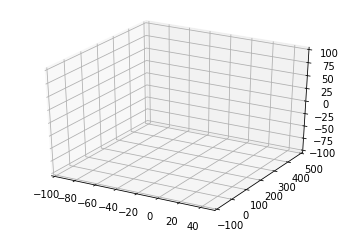

In [122]:
#Creating an empty plot space
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim3d(-100, 50)
ax.set_ylim3d(-100,500)
ax.set_zlim3d(-100,100)

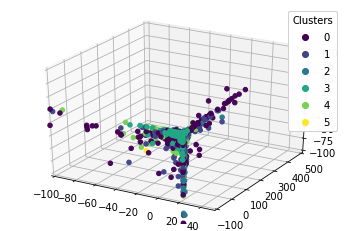

In [123]:
#Creating a Scatterplot
img=ax.scatter3D(kmeans_pd_scatter.pca1, kmeans_pd_scatter.pca2, kmeans_pd_scatter.pca3, c=kmeans_pd_scatter.prediction)
legend1 = ax.legend(*img.legend_elements(num=6),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
fig

## Latent Dirchlett Allocation(LDA) - Topic Modelling

### Extracting the LDA model 

In [42]:
lda_model = pipelineFit_1.stages[-1]
lda_model.describeTopics(maxTermsPerTopic=8).show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[187, 66, 158, 16...|[0.12736324531075...|
|    1|[11, 61, 103, 21,...|[0.04768861796895...|
|    2|[4, 127, 104, 77,...|[0.04489169002948...|
|    3|[4, 103, 11, 22, ...|[0.21218944289608...|
|    4|[26, 28, 156, 67,...|[0.27917688712795...|
|    5|[31, 4, 60, 247, ...|[0.03960944208882...|
+-----+--------------------+--------------------+



In [43]:
terms_matrix=np.array(lda_model.describeTopics().rdd.map(lambda x: x['termIndices']).collect())

In [44]:
vocabulary = pipelineFit_1.stages[2].vocabulary

In [45]:
np.array(vocabulary)[terms_matrix]

array([['dogs', 'cov', 'mers', 'vaccine', 'mention', 'sars', 'r', 'p',
        'cases', 'influenza'],
       ['cells', 'mice', 'ifn', 'cell', 'expression', 'hiv', 'protein',
        'proteins', 'anti', 'antibody'],
       ['mention', 'sequences', 'sequence', 'pcr', 'rna', 'genome',
        'strains', 'genes', 'rt', 'dna'],
       ['mention', 'ifn', 'cells', 'protein', 'proteins', 'expression',
        'mice', 'replication', 'cell', 'materials'],
       ['t', 'n', 'il', 'm', 'h', 'd', 'r', 'q', 'mention', '0'],
       ['patients', 'mention', 'health', 'children', 'influenza', 'risk',
        'cases', 'age', 'public', 'patient']], dtype='<U13')

## Supervised Classification

### Creating Labels for our topic model output

In [46]:
Classification_df = kmeans_df.withColumn('Topic',
                                        F.when(F.col("prediction")==0,"Vaccinations & Theraputics")\
                                         .when(F.col("prediction")==1,"Antibodies Litrature")\
                                         .when(F.col("prediction")==2,"Genomes")\
                                         .when(F.col("prediction")==3,"Disease Structures")\
                                         .when(F.col("prediction")==4,"Others")\
                                         .when(F.col("prediction")==5,"Effects on public health"))

In [47]:
Classification_df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- Microsoft Academic Paper ID: string (nullable = true)
 |-- WHO #Covidence: string (nullable = true)
 |-- has_pdf_parse: string (nullable = true)
 |-- has_pmc_xml_parse: string (nullable = true)
 |-- full_text_file: string (nullable = true)
 |-- url: string (nullable = true)
 |-- abstract_word_count: integer (nullable = false)
 |-- body_word_count: integer (nullable = false)
 |-- body_text_tokenized: array (nullable = true)
 |    |-- elemen

### Creating train and test datasets 

In [49]:
#Defining schema of the dataset
def generate_class_schema():
    return StructType(
        [
            StructField("pca1", FloatType()),
            StructField("pca2", FloatType()),
            StructField("pca3", FloatType()),
            StructField("prediction", IntegerType()),
        ]
    )

In [50]:
#Creating a dataset for classification
Classification_df=spark.createDataFrame(kmeans_pd_2,schema=generate_class_schema())
Classification_df2=Classification_df.select('pca1','pca2','pca3',col("prediction").alias("ClusterNo"))
Classification_df2.show(5)

+----------+---------+----------+---------+
|      pca1|     pca2|      pca3|ClusterNo|
+----------+---------+----------+---------+
| -3.412142|20.697002| -9.691759|        4|
|-16.903866| 5675.063| -40.25595|        0|
| -2.957218|16.342445| -46.41042|        1|
|  -44.8746| 5389.236| 48.205017|        0|
| 0.9273219|93.260376|-47.898407|        0|
+----------+---------+----------+---------+
only showing top 5 rows



In [51]:
#Creating the train and test datasets
train,test = Classification_df2.randomSplit([0.8,0.2],42)

In [112]:
#Specifying the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='ClusterNo',metricName="weightedRecall")

## Logistic Regression 

In [99]:
model1 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pca1','pca2','pca3'], outputCol='features'),
                 LogisticRegression(maxIter=100,labelCol='ClusterNo', featuresCol='features',elasticNetParam=0.1,family="multinomial")])
model1_fitted = model1.fit(train)

#### Train Accuracy 

In [113]:
evaluator.evaluate(model1_fitted.transform(train))

0.4629577464788733

#### Test Accuracy 

In [114]:
evaluator.evaluate(model1_fitted.transform(test))

0.41953698475437606

## MultiLayerPercptron

In [88]:
layers = [3,35,20,6]
model2 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pca1','pca2','pca3'], outputCol='features'),
                          MultilayerPerceptronClassifier(layers=layers,labelCol='ClusterNo', featuresCol='features')])
model2_fitted = model2.fit(train)

#### Train Accuracy 

In [115]:
evaluator.evaluate(model2_fitted.transform(train))

0.5645070422535211

#### Test Accuracy 

In [116]:
evaluator.evaluate(model2_fitted.transform(test))

0.5431959345002824

## Decision Tree 

In [70]:
model3 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pca1','pca2','pca3'], outputCol='features'),
                          DecisionTreeClassifier(labelCol='ClusterNo', featuresCol='features')])

model3_fitted = model3.fit(train)

#### Train Accuracy 

In [117]:
evaluator.evaluate(model3_fitted.transform(train))

0.6046478873239436

#### Test Accuracy 

In [118]:
evaluator.evaluate(model3_fitted.transform(test))

0.5640880858272163

## Random Forest

In [94]:
model4 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pca1','pca2','pca3'], outputCol='features'),
                          RandomForestClassifier(labelCol='ClusterNo', featuresCol='features',numTrees=150,maxDepth=10)])

model4_fitted = model4.fit(train)

#### Train Accuracy 

In [119]:
evaluator.evaluate(model4_fitted.transform(train))

0.7440845070422535

#### Test Accuracy 

In [120]:
evaluator.evaluate(model4_fitted.transform(test))

0.616600790513834

# Conclusion 

From our analysis we were able to sucessfully cluster the research papers based on the tasks mentioned in Kaggle challenge. In our proess of clustering - topic modelling - classification. 

We were able to sucessfully cluster the papers using the Kmeans algorithm with 6 clusters. 

Furthermore, we were able to get pretty accurate mapping in the resultant clusters for our topic modelling that identified latent relations between the text present in the papers.

Finally, we were able to verify our PC components using the classification exercise where we were able to classify our papers accurately using the Random Forest algorithm which gave us close to 62% accuracy which can be considered as pretty decent number for this exercise

# Appendix - For Reference Only

Please note that the code in this section is for reference only. Do not run this section below this

## 1. K-Means Elbow Graph 

In [ ]:
raise NotImplementedError()

In [128]:
#kmeans
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('norm_tfidf')
    model = kmeans.fit(norm_df)
    cost[k] = model.computeCost(norm_df)


In [129]:
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [1,2,3,4,5,6,7,8]
df_cost.insert(0, 'cluster', new_col)

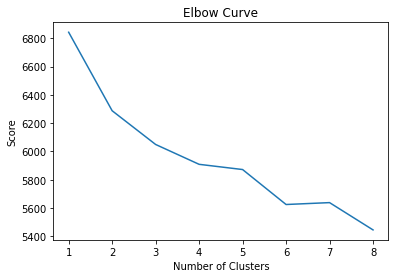

In [130]:
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

## 2. Modelling with 2 PCA components

In [278]:
def pca_pred_df(df):
    pca_1=[]
    pca_2=[]
    for i in range(len(kmeans_pd)):
        x = df['PCA_Scores'][i][0]
        y = df['PCA_Scores'][i][1]
        prediction = df['prediction']
        pca_1.append(x)
        pca_2.append(y)
    dict = {'pca1': pca_1, 'pca2': pca_2, 'prediction' : prediction}
    final_df = pd.DataFrame(dict)
    return final_df

[(-100.0, 500.0), (-100.0, 50.0)]

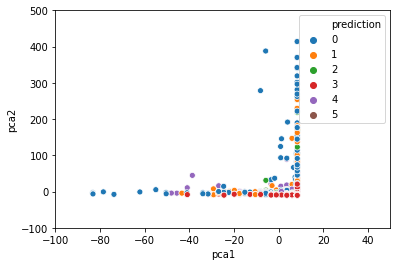

In [312]:
sns.scatterplot(x="pca1",y='pca2',hue='prediction',data=kmeans_pd_scatter).set(xlim=(-100,50),ylim=(-100,500))

## 2. PCA Explained Variance Iterations 

In [ ]:
#pca

pca=PCA(k=2, inputCol="centered_tfidf", outputCol="PCA_Scores")

PCA_model = pca.fit(tfidf_df).transform(tfidf_df)

##tfidf_df.explainedVariance # provides the variance of features,we had provided .95 variance level.
## DenseVector([0.9244, 0.0456])

PCA_df = PCA_model.transform(tfidf_df)
PCA_df.select("paper_id","tfidf","PCA_Scores").show(n=5)
PCA_model.explainedVariance

## 3. Supervised Learning (with 2 PCs) 

### 3.1 Logistic Regression

##### Training Accuracy 

In [385]:
evaluator.evaluate(model1_fitted.transform(train))

0.3157041588835755

##### Test Accuracy 

In [374]:
evaluator.evaluate(model1_fitted.transform(test))

0.28069481637321425

### 3.2  Decision Tree

##### Training Accuracy 

In [386]:
evaluator.evaluate(model2_fitted.transform(train))

0.5642372039022637

##### Test Accuracy 

In [323]:
evaluator.evaluate(model2_fitted.transform(test))

0.5321334431546968

### 3.3 Random Forest 

##### Training Accuracy 

In [387]:
evaluator.evaluate(model3_fitted.transform(train))

0.5938086629150545

##### Test Accuracy 

In [351]:
evaluator.evaluate(model3_fitted.transform(test))

0.5498105994002982

### 3.4 Multi Layer Perceptron 

##### Training Accuracy 

In [388]:
evaluator.evaluate(model4_fitted.transform(train))

0.31306567237831795

##### Test Accuracy 

In [384]:
evaluator.evaluate(model4_fitted.transform(test))

0.27582083032706867